In [1]:
import torch
import torchvision

import time

from torch import nn
from einops import rearrange, reduce
from argparse import ArgumentParser
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from skimage.color import rgb2lab, lab2rgb

import datetime

img_size = 64

In [2]:
class Encoder(nn.Module):
    def __init__(self, n_features=1, kernel_size=3, n_filters=32, feature_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(n_features, n_filters, kernel_size=kernel_size, stride=2)
        # self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(n_filters, n_filters*2, kernel_size=kernel_size, stride=2)
        # self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(n_filters*2, n_filters*4, kernel_size=kernel_size, stride=2)
        # self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(6272, feature_dim)
        
    def forward(self, x):
        y = nn.ReLU()(self.conv1(x))
        y = nn.ReLU()(self.conv2(y))
        y = nn.ReLU()(self.conv3(y))
        y = y.view(y.size(0), -1)
        y = self.fc1(y)
        return y

encoder = Encoder(n_features=1)
x = torch.Tensor(1, 1, img_size, img_size)
h = encoder(x)
print("h.shape:", h.shape)

h.shape: torch.Size([1, 256])


In [3]:
class Decoder(nn.Module):
    def __init__(self, kernel_size=3, n_filters=256, feature_dim=256, output_size=img_size, output_channels=3):
        super().__init__()
        self.init_size = output_size // 2**2 
        self.fc1 = nn.Linear(feature_dim, self.init_size**2 * n_filters)
        self.conv1 = nn.ConvTranspose2d(n_filters, n_filters//2, kernel_size=kernel_size, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(n_filters//2, n_filters//4, kernel_size=kernel_size, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(n_filters//4, n_filters//4, kernel_size=kernel_size, padding=1)
        self.conv4 = nn.ConvTranspose2d(n_filters//4, output_channels, kernel_size=kernel_size+1)

    def forward(self, x):
        B, _ = x.shape
        y = self.fc1(x)
        y = y.reshape(B, -1, self.init_size, self.init_size)
        y = nn.ReLU()(self.conv1(y))
        y = nn.ReLU()(self.conv2(y))
        y = nn.ReLU()(self.conv3(y))
        y = nn.Hardsigmoid()(self.conv4(y))

        return y


In [4]:
resize = torchvision.transforms.Compose([torchvision.transforms.Resize((img_size, img_size)), torchvision.transforms.ToTensor()])

In [5]:
import pytorch_lightning as L

def gray_collate_fn(batch):
    x, _ = zip(*batch)

    x = torch.stack(x, dim=0)
    xn = torch.mean(x, dim=1, keepdim=True)

    return xn, x

# def gray_collate_fn(batch):
#     x, _ = batch

#     x_new = torch.zeros_like(x)

#     i = 0
#     for val in x:
#         x_new[i] = rgb2lab(val)
#         i+=1

#     return x_new, x

class Colorizer(L.LightningModule):
    def __init__(self, feature_dim=256, lr=0.001, batch_size=32,
                 num_workers=10, max_epochs=30, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(feature_dim=feature_dim)
        self.decoder = Decoder(feature_dim=feature_dim)
        self.loss = nn.MSELoss()
        self.train_losses = []
        self.test_losses = []

        self.step = 0

    def forward(self, x):
        h = self.encoder(x)
        x_tilde = self.decoder(h)
        return x_tilde

    def on_train_epoch_start(self) -> None:
        self.train_losses.clear()
    
    def training_step(self, batch, batch_idx):
        x_in, x = batch

        x_tilde = self.forward(x_in)
        loss = self.loss(x_tilde, x)
        self.train_losses.append(loss)

        if self.step % 10000 == 0 and self.step != 0:
            print(f"Step {self.step:03d} | Loss: {loss.item()}")
            
            dict = self.state_dict()

            dict["pytorch-lightning_version"] = '2.1.0'
            dict["global_step"] = self.step
            dict["epoch"] = self.current_epoch
            dict["state_dict"] = self.state_dict()

            now = datetime.datetime.now()

            dt_string = now.strftime("%d|%m|%Y %H:%M:%S")
            
            torch.save(dict, "saves/diffusion_model_step: " + self.step.__str__() + "|time: " + dt_string + ".ckpt")

        self.step += 1

        return {"loss": loss}

    def on_train_epoch_end(self):
        avg_loss = torch.stack([x for x in self.train_losses]).mean()
        self.log("train_loss", avg_loss, on_epoch=True, prog_bar=True)

    def on_test_epoch_start(self):
        self.test_losses.clear()

    def test_step(self, batch, batch_idx):
        x_in, x = batch
        x_tilde = self.forward(x_in)
        loss = self.loss(x_tilde, x)
        self.test_losses.append(loss)
        return {"test_loss" : loss,}

    def on_test_epoch_end(self):
        avg_loss = torch.stack([x for x in self.test_losses]).mean()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)

    def on_validation_epoch_start(self) -> None:
        return self.on_test_epoch_start()

    def validation_step(self, batch, batch_idx):
       return self.test_step(batch, batch_idx)

    def on_validation_epoch_end(self):
        return self.on_test_epoch_end()
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler], 
    
    def setup(self, stage=None):
        self.train_dataloader()
        self.test_dataloader()

    def train_dataloader(self):        
        return torch.utils.data.DataLoader(
            torchvision.datasets.ImageFolder(
                "/home/maxim/Downloads/archive (2)/img_align_celeba/", 
                transform=resize
            ),
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
            collate_fn=gray_collate_fn
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.ImageFolder(
                "/home/maxim/Downloads/archive (2)/val/", 
                transform=resize
            ),
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
            collate_fn=gray_collate_fn
        )

    def val_dataloader(self):
        return self.test_dataloader()

0.034 - normal
0.0328 - hard
0.0331 - none

0.0346 - 3 channel RGB
0.0328 - 1 channel RGB

0.0315 - pool / 4m 12s
0.0328 - stride / 3m 32s

In [6]:
model = Colorizer()

# model = Colorizer.load_from_checkpoint('saves/diffusion_model_step: 10000|time: 18|12|2023 21:34:34.ckpt')

trainer = L.Trainer(max_epochs=1, accelerator="cuda", precision='16-mixed')
trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 1.7 M 
1 | decoder | Decoder | 17.3 M
2 | loss    | MSELoss | 0     
------------------------------------
19.0 M    Trainable params
0         Non-trainable params
19.0 M    Total params
75.801    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


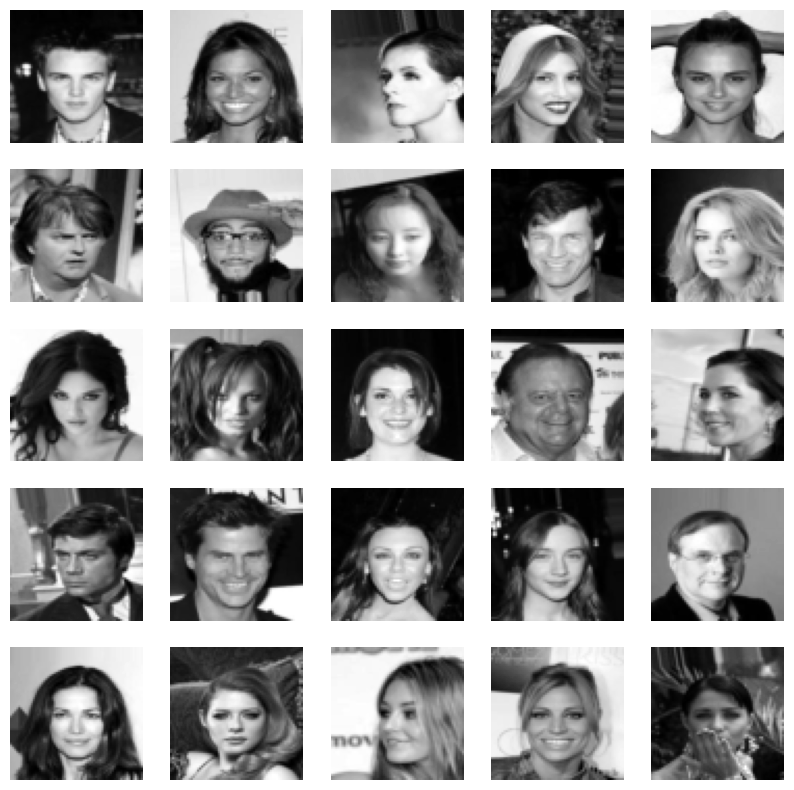

In [7]:
import matplotlib.pyplot as plt

test_dl = model.test_dataloader()
test_batch = next(iter(test_dl))
x_in, x = test_batch
x_in = x_in[:25]

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        idx = i*5 + j
        axs[i, j].imshow(x_in[idx].squeeze(), cmap='gray')
        axs[i, j].axis('off')
plt.show()

with torch.no_grad():
    x_tilde = model(x_in)

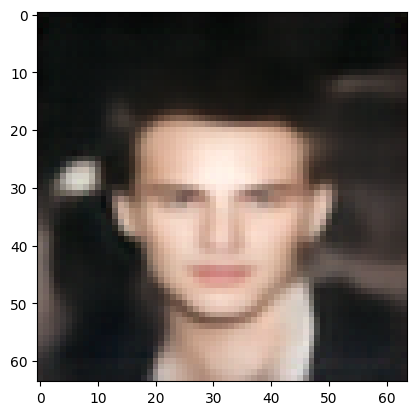

In [8]:

plt.imshow(x_tilde[0].permute(1, 2, 0))

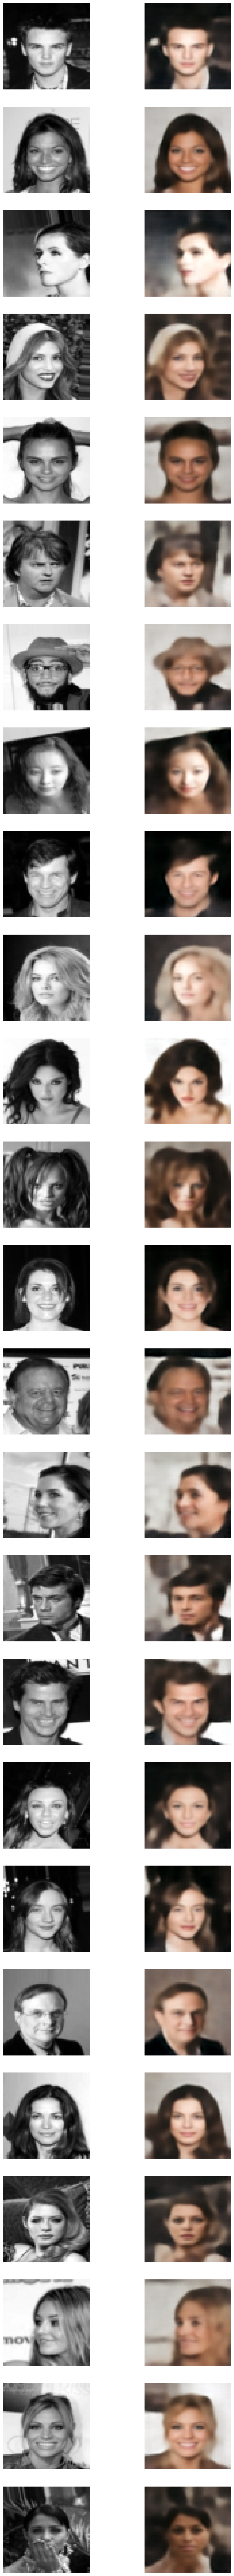

In [9]:
import matplotlib.pyplot as plt

test_dl = model.test_dataloader()
test_batch = next(iter(test_dl))
x_in, x = test_batch
x_in = x_in[:25]

with torch.no_grad():
    x_tilde = model(x_in)

fig, axs = plt.subplots(nrows=25, ncols=2, figsize=(10, 100))
for i in range(25):
    axs[i, 0].imshow(x_in[i].squeeze(), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(x_tilde[i].permute(1, 2, 0))
    axs[i, 1].axis('off')
plt.show()
